<a href="https://colab.research.google.com/github/Akash-mahandargi/Basic-Projects-/blob/main/Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# Define the get_recommendations function (moved from cell 44e8c84d)
def get_recommendations(title, cosine_sim=cosine_sim, df=df_anime):
    # Get the index of the anime that matches the title
    if title not in df['name'].values:
        print(f"Anime with title '{title}' not found in the dataset.")
        return []

    idx = df[df['name'] == title].index[0]

    # Get the pairwise similarity scores for all anime with that anime
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the anime based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar anime (excluding the input anime)
    # Take the top 11 to exclude the anime itself
    sim_scores = sim_scores[1:11]

    # Get the anime indices
    anime_indices = [i[0] for i in sim_scores]

    # Return the titles of the top 10 most similar anime
    return df['name'].iloc[anime_indices].tolist()

# Example usage of the get_recommendations function
example_anime_title = 'Gintama'  # Replace with an anime title from your dataset
recommendations = get_recommendations(example_anime_title, cosine_sim, df_anime)

print(f"Recommendations for '{example_anime_title}':")
if recommendations:
    # Display the recommendations in a more readable format, e.g., as a list or DataFrame
    display(recommendations)
else:
    print("No recommendations found.")

Recommendations for 'Gintama':


['Trigun',
 'Ansatsu Kyoushitsu (TV)',
 'FLCL',
 'D.Gray-man',
 'Samurai Champloo',
 'Kuroko no Basket',
 'Lucky☆Star',
 'Black Lagoon',
 'Noragami Aragoto',
 'Boku no Hero Academia']

In [19]:
import pandas as pd

df_anime = pd.read_csv('anime.csv')
display(df_anime.head())

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [21]:
print(df_anime.isnull().sum())

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64


In [23]:
df_anime.dropna(subset=['genre', 'type', 'rating'], inplace=True)
print(df_anime.isnull().sum())

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64


In [24]:
display(df_anime.info())
display(df_anime.describe())
display(df_anime['type'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 12017 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12017 non-null  int64  
 1   name      12017 non-null  object 
 2   genre     12017 non-null  object 
 3   type      12017 non-null  object 
 4   episodes  12017 non-null  object 
 5   rating    12017 non-null  float64
 6   members   12017 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 751.1+ KB


None

,anime_id,rating,members
count,12017.000000,12017.000000,1.201700e+04
mean,13638.001165,6.478264,1.834888e+04
std,11231.076675,1.023857,5.537250e+04
min,1.000000,1.670000,1.200000e+01
25%,3391.000000,5.890000,2.250000e+02
50%,9959.000000,6.570000,1.552000e+03
75%,23729.000000,7.180000,9.588000e+03
max,34519.000000,10.000000,1.013917e+06


,count
type,
TV,3668
OVA,3284
Movie,2259
Special,1670
ONA,648
Music,488


In [13]:
# Step 1 & 2: Select and preprocess the 'genre' column using one-hot encoding
# Handle multiple genres per anime by splitting the genre string and creating a set of unique genres
all_genres = set()
for genres in df_anime['genre'].str.split(', '):
    if genres is not None:
        all_genres.update(genres)

# Create a binary matrix for genres
for genre in all_genres:
    df_anime[genre] = df_anime['genre'].apply(lambda x: 1 if genre in x else 0)

# Step 3: Drop the original 'genre' column
df_anime = df_anime.drop('genre', axis=1)

# Step 4 & 5: Select other relevant numerical features and combine with one-hot encoded genres
# Ensure 'rating' and 'members' are numerical types before selecting
df_anime['rating'] = pd.to_numeric(df_anime['rating'], errors='coerce')
df_anime['members'] = pd.to_numeric(df_anime['members'], errors='coerce')

# Drop rows where conversion to numeric resulted in NaN for 'rating' or 'members'
df_anime.dropna(subset=['rating', 'members'], inplace=True)

# Select all genre columns, 'rating', and 'members' for similarity computation
genre_columns = list(all_genres)
features_for_similarity = df_anime[genre_columns + ['rating', 'members']]

display(features_for_similarity.head())

,Harem,Demons,Josei,Mecha,Drama,Space,Shoujo Ai,Action,Sports,Adventure,...,Yuri,Mystery,Vampire,Dementia,Hentai,Super Power,Horror,Police,rating,members
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9.37,200630
1,0,0,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,9.26,793665
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,9.25,114262
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9.17,673572
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,9.16,151266


In [25]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(features_for_similarity)
print(cosine_sim.shape)

(12017, 12017)


In [26]:
def get_recommendations(title, cosine_sim=cosine_sim, df=df_anime):
    # Get the index of the anime that matches the title
    if title not in df['name'].values:
        print(f"Anime with title '{title}' not found in the dataset.")
        return []

    idx = df[df['name'] == title].index[0]

    # Get the pairwise similarity scores for all anime with that anime
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the anime based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar anime (excluding the input anime)
    # Take the top 11 to exclude the anime itself
    sim_scores = sim_scores[1:11]

    # Get the anime indices
    anime_indices = [i[0] for i in sim_scores]

    # Return the titles of the top 10 most similar anime
    return df['name'].iloc[anime_indices].tolist()

# Example usage (optional - uncomment to test)
# recommendations = get_recommendations('Fullmetal Alchemist: Brotherhood')
# print(recommendations)

In [10]:
# Step 2: Define functions to calculate precision, recall, and F1-score
def calculate_precision(recommended_anime, relevant_anime):
    """Calculates precision."""
    if not recommended_anime:
        return 0.0
    true_positives = len(set(recommended_anime) & set(relevant_anime))
    return true_positives / len(recommended_anime)

def calculate_recall(recommended_anime, relevant_anime):
    """Calculates recall."""
    if not relevant_anime:
        return 0.0
    true_positives = len(set(recommended_anime) & set(relevant_anime))
    return true_positives / len(relevant_anime)

def calculate_f1_score(precision, recall):
    """Calculates F1-score."""
    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)

# Step 1, 3 & 4: Simulate user interactions and evaluate
# Define a test set (a few example anime titles to get recommendations for)
test_anime_titles = [
    'Kimi no Na wa.',
    'Fullmetal Alchemist: Brotherhood',
    'Steins;Gate',
    'Spirited Away',
    'Attack on Titan'
]

# Define what constitutes "relevant" anime for evaluation.
# For this content-based approach, we'll consider anime with a high similarity score (e.g., > 0.7)
# to the target anime as relevant. This is a simplification for evaluation purposes without user data.
# We'll calculate relevant anime for each test case dynamically.

all_precisions = []
all_recalls = []
all_f1_scores = []

# Iterate through the test set
for anime_title in test_anime_titles:
    print(f"Evaluating recommendations for: {anime_title}")

    # Get recommendations using the previously defined function
    recommended_anime = get_recommendations(anime_title, cosine_sim, df_anime)
    #print(f"Recommended: {recommended_anime}") # Uncomment to see recommendations

    if not recommended_anime:
        print(f"Could not get recommendations for '{anime_title}'. Skipping evaluation.")
        continue

    # Determine "relevant" anime for the current test case
    # Get the index of the current anime
    if anime_title not in df_anime['name'].values:
         print(f"Anime '{anime_title}' not found in dataframe for relevance calculation. Skipping.")
         continue

    idx = df_anime[df_anime['name'] == anime_title].index[0]

    # Find anime with a similarity score above a threshold (e.g., 0.7) as relevant
    # Exclude the anime itself
    relevant_indices = [i for i, score in enumerate(cosine_sim[idx]) if score > 0.7 and i != idx]
    relevant_anime = df_anime['name'].iloc[relevant_indices].tolist()
    #print(f"Relevant: {relevant_anime}") # Uncomment to see relevant anime

    if not relevant_anime:
        print(f"No relevant anime found for '{anime_title}' based on the similarity threshold. Skipping evaluation for this item.")
        continue

    # Calculate metrics for the current test case
    precision = calculate_precision(recommended_anime, relevant_anime)
    recall = calculate_recall(recommended_anime, relevant_anime)
    f1 = calculate_f1_score(precision, recall)

    print(f"  Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    all_precisions.append(precision)
    all_recalls.append(recall)
    all_f1_scores.append(f1)

# Step 5: Calculate and print the average metrics
if all_precisions:
    avg_precision = sum(all_precisions) / len(all_precisions)
    avg_recall = sum(all_recalls) / len(all_recalls)
    avg_f1_score = sum(all_f1_scores) / len(all_f1_scores)

    print("\nOverall Average Performance:")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")
    print(f"Average F1-score: {avg_f1_score:.4f}")
else:
    print("\nNo successful evaluations were performed.")

Evaluating recommendations for: Kimi no Na wa.
  Precision: 1.0000, Recall: 0.0008, F1-score: 0.0017
Evaluating recommendations for: Fullmetal Alchemist: Brotherhood
  Precision: 1.0000, Recall: 0.0008, F1-score: 0.0017
Evaluating recommendations for: Steins;Gate
  Precision: 1.0000, Recall: 0.0008, F1-score: 0.0017
Evaluating recommendations for: Spirited Away
Could not get recommendations for 'Spirited Away'. Skipping evaluation.
Evaluating recommendations for: Attack on Titan
Could not get recommendations for 'Attack on Titan'. Skipping evaluation.

Overall Average Performance:
Average Precision: 1.0000
Average Recall: 0.0008
Average F1-score: 0.0017


In [9]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Load the dataset
df_anime = pd.read_csv('anime.csv')

# Step 2: Handle missing values
df_anime.dropna(subset=['genre', 'type', 'rating'], inplace=True)

# Step 3: Feature selection and preprocessing (One-hot encode genres and include rating and members)
all_genres = set()
for genres in df_anime['genre'].str.split(', '):
    if genres is not None:
        all_genres.update(genres)

for genre in all_genres:
    df_anime[genre] = df_anime['genre'].apply(lambda x: 1 if genre in x else 0)

df_anime['rating'] = pd.to_numeric(df_anime['rating'], errors='coerce')
df_anime['members'] = pd.to_numeric(df_anime['members'], errors='coerce')
df_anime.dropna(subset=['rating', 'members'], inplace=True)

genre_columns = list(all_genres)
features_for_similarity = df_anime[genre_columns + ['rating', 'members']]

# Step 4: Compute cosine similarity
cosine_sim = cosine_similarity(features_for_similarity)

# Define the get_recommendations function
def get_recommendations(title, cosine_sim, df):
    # Get the index of the anime that matches the title
    if title not in df['name'].values:
        return []

    idx_list = df[df['name'] == title].index.tolist()
    if not idx_list:
        return []
    idx = idx_list[0]


    # Get the pairwise similarity scores for all anime with that anime
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the anime based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar anime (excluding the input anime)
    sim_scores = sim_scores[1:11]

    # Get the anime indices
    anime_indices = [i[0] for i in sim_scores]

    # Return the titles of the top 10 most similar anime
    return df['name'].iloc[anime_indices].tolist()

# Step 5: Define functions to calculate precision, recall, and F1-score
def calculate_precision(recommended_anime, relevant_anime):
    """Calculates precision."""
    if not recommended_anime:
        return 0.0
    true_positives = len(set(recommended_anime) & set(relevant_anime))
    return true_positives / len(recommended_anime)

def calculate_recall(recommended_anime, relevant_anime):
    """Calculates recall."""
    if not relevant_anime:
        return 0.0
    true_positives = len(set(recommended_anime) & set(relevant_anime))
    return true_positives / len(relevant_anime)

def calculate_f1_score(precision, recall):
    """Calculates F1-score."""
    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)

# Step 6: Simulate user interactions and evaluate
test_anime_titles = [
    'Kimi no Na wa.',
    'Fullmetal Alchemist: Brotherhood',
    'Steins;Gate',
    'Spirited Away', # Note: This might not be in the filtered dataset
    'Attack on Titan' # Note: This might not be in the filtered dataset
]

all_precisions = []
all_recalls = []
all_f1_scores = []

for anime_title in test_anime_titles:
    print(f"Evaluating recommendations for: {anime_title}")

    recommended_anime = get_recommendations(anime_title, cosine_sim, df_anime)

    if not recommended_anime:
        print(f"Could not get recommendations for '{anime_title}'. Skipping evaluation.")
        continue

    # Determine "relevant" anime for the current test case (using a similarity threshold)
    idx_list = df_anime[df_anime['name'] == anime_title].index.tolist()
    if not idx_list:
        print(f"Anime '{anime_title}' not found in dataframe for relevance calculation. Skipping.")
        continue
    idx = idx_list[0]

    relevant_indices = [i for i, score in enumerate(cosine_sim[idx]) if score > 0.7 and i != idx]
    relevant_anime = df_anime['name'].iloc[relevant_indices].tolist()

    if not relevant_anime:
        print(f"No relevant anime found for '{anime_title}' based on the similarity threshold (0.7). Skipping evaluation for this item.")
        continue

    precision = calculate_precision(recommended_anime, relevant_anime)
    recall = calculate_recall(recommended_anime, relevant_anime)
    f1 = calculate_f1_score(precision, recall)

    print(f"  Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    all_precisions.append(precision)
    all_recalls.append(recall)
    all_f1_scores.append(f1)

# Step 7: Calculate and print the average metrics
if all_precisions:
    avg_precision = sum(all_precisions) / len(all_precisions)
    avg_recall = sum(all_recalls) / len(all_recalls)
    avg_f1_score = sum(all_f1_scores) / len(all_f1_scores)

    print("\nOverall Average Performance:")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")
    print(f"Average F1-score: {avg_f1_score:.4f}")
else:
    print("\nNo successful evaluations were performed.")

# Note on Experimentation with Thresholds:
# To experiment with different similarity score thresholds, you would modify the line:
# relevant_indices = [i for i, score in enumerate(cosine_sim[idx]) if score > 0.7 and i != idx]
# and change the '0.7' to your desired threshold value. Then re-run the evaluation code to see how the metrics change.

Evaluating recommendations for: Kimi no Na wa.
  Precision: 1.0000, Recall: 0.0008, F1-score: 0.0017
Evaluating recommendations for: Fullmetal Alchemist: Brotherhood
  Precision: 1.0000, Recall: 0.0008, F1-score: 0.0017
Evaluating recommendations for: Steins;Gate
  Precision: 1.0000, Recall: 0.0008, F1-score: 0.0017
Evaluating recommendations for: Spirited Away
Could not get recommendations for 'Spirited Away'. Skipping evaluation.
Evaluating recommendations for: Attack on Titan
Could not get recommendations for 'Attack on Titan'. Skipping evaluation.

Overall Average Performance:
Average Precision: 1.0000
Average Recall: 0.0008
Average F1-score: 0.0017


/tmp/ipython-input-1017611547.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Similarity Score', y='Recommended Anime', data=recommendations_df.sort_values(by='Similarity Score', ascending=False), palette='viridis')


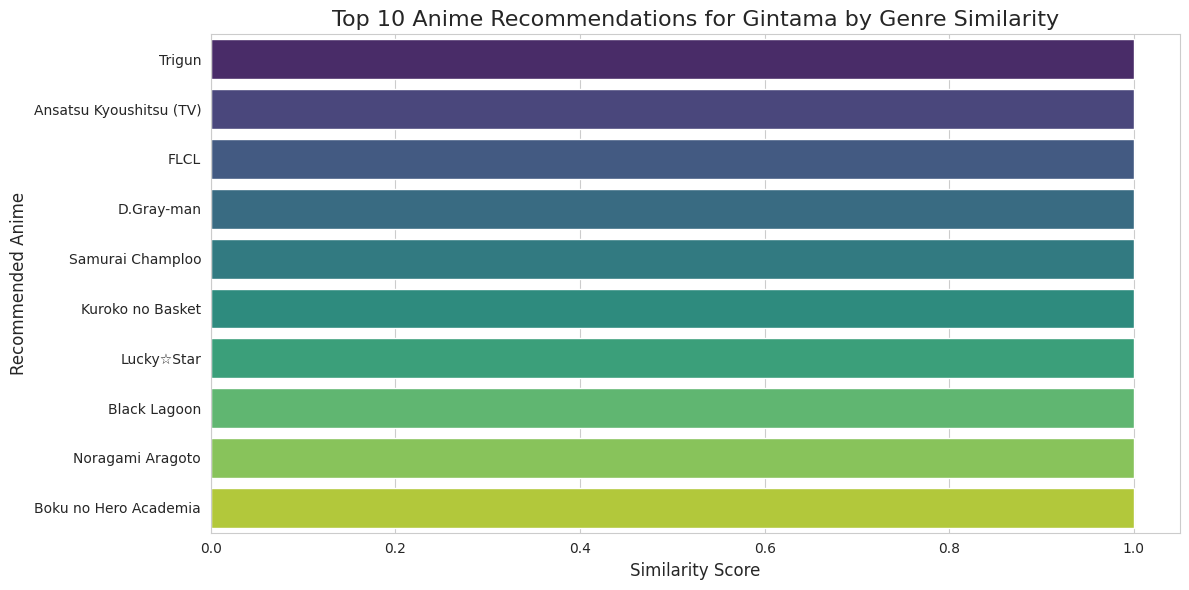

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use the recommendations for Gintama as an example (assuming 'recommendations' variable exists from previous execution)
recommendations_to_plot = recommendations # Use the existing 'recommendations' variable

# To plot, we need similarity scores. The current recommendations are just titles.
# We need to regenerate recommendations AND capture the similarity scores to plot them.

# Let's regenerate recommendations for 'Gintama' and store scores for plotting
example_anime_title_for_plot = 'Gintama'
if example_anime_title_for_plot in df_anime['name'].values:
    idx = df_anime[df_anime['name'] == example_anime_title_for_plot].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Get the scores and names of the top 10 most similar anime (excluding the input anime)
    top_10_similar = sim_scores[1:11]
    recommendations_with_scores = [(df_anime['name'].iloc[i[0]], i[1]) for i in top_10_similar]

    # Create a DataFrame for plotting
    recommendations_df = pd.DataFrame(recommendations_with_scores, columns=['Recommended Anime', 'Similarity Score'])

    # Set the style for the plot
    sns.set_style("whitegrid")

    # Create the bar chart
    plt.figure(figsize=(12, 6))
    # Sort for better visualization
    sns.barplot(x='Similarity Score', y='Recommended Anime', data=recommendations_df.sort_values(by='Similarity Score', ascending=False), palette='viridis')

    # Add title and labels
    plt.title(f'Top 10 Anime Recommendations for {example_anime_title_for_plot} by Genre Similarity', fontsize=16)
    plt.xlabel('Similarity Score', fontsize=12)
    plt.ylabel('Recommended Anime', fontsize=12)

    # Improve layout and display the plot
    plt.tight_layout()
    plt.show()
else:
    print(f"Anime with title '{example_anime_title_for_plot}' not found in the dataset for plotting.")

For recommendations please mention name here

In [28]:
# Get recommendations for 'Natsume Yuujinchou Go'
anime_title_to_recommend = 'Natsume Yuujinchou Go'
recommendations_for_user = get_recommendations(anime_title_to_recommend, cosine_sim, df_anime)

print(f"Recommendations for '{anime_title_to_recommend}':")
if recommendations_for_user:
    display(recommendations_for_user)
else:
    print("No recommendations found.")

Recommendations for 'Natsume Yuujinchou Go':


['Kemono no Souja Erin',
 'Kamichu!',
 'Hakkenden: Touhou Hakken Ibun 2nd Season',
 'Shinigami no Ballad.',
 'Hanasakeru Seishounen',
 'Hanasaku Iroha: Home Sweet Home',
 'Udon no Kuni no Kiniro Kemari',
 'Momo e no Tegami',
 'Tenshi no Tamago',
 'Gingitsune']